<a href="https://colab.research.google.com/github/sharifkaiser/DL_colab/blob/master/fashion_mnist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Most of the code here will be as fashion_mnist practice, except that here we will use convolutional neural network (CNN) in addition with dense layers to improve our model, and a few changes for improvement.

*tfds* We will use tfds dataset instead of keras since úsing keras can have some problems with input dimensioning

*Batch* We will add batch of 32 here: this will be helpful when we will have a large amount of data that might take a few days to run. With batches, we can see current progress

*Shuffle* We will use shuffle here, so that our model cannot memorize any pattern

*Cache* We will cache dataset (both training and test) if possible, so that it does not download every time

In [ ]:
from __future__ import absolute_import, print_function, division
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import math

# import tensor flow and keras
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


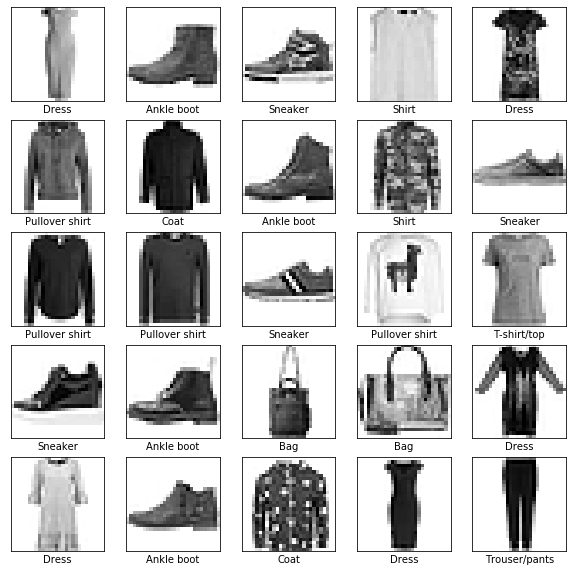

Train for 1875 steps
Epoch 1/3
1875/1875 [==============================] - 100s 54ms/step - loss: 0.5080 - accuracy: 0.8476
Epoch 2/3
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2846 - accuracy: 0.8953
Epoch 3/3
1875/1875 [==============================] - 87s 47ms/step - loss: 0.2437 - accuracy: 0.9110


In [ ]:
# you can find fashion_mnist here: https://www.tensorflow.org/datasets/catalog/fashion_mnist
# detailed tutorial about how to work with datase: https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)  # load() returns tf.data.Dataset
train_dataset, test_dataset = dataset['train'], dataset['test']


# check how the dataset looks like, to do ???
# print(list(dataset.take(1)))
# all_dataset = dataset['all']
# train_Numpy = train_dataset.batch(1000).make_one_shot_iterator().get_next()[0].numpy()
# print(train_Numpy.shape)

class_names = [
                'T-shirt/top',
                'Trouser/pants',
                'Pullover shirt',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle boot'
              ]

# cache
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Normalizinh speeds up the training of a neural network
# A target variable with a large spread of values, in turn, may result in large error gradient values 
# causing weight values to change dramatically, making the learning process unstable.
# Scaling input and output variables is a critical step in using neural network models.
def normalize(image, label):
  # in image /= 255.0, we divide image by a floating number (255.0), but we are not sure about type of image
  # in python, always convert type before operation
  image = tf.cast(image, tf.float32)  # image is type tensorflow so conversion using tf
  #image /= 255.0  # each image pixel had numbers between 0 and 255, now the number will be between 0 and 1
  return image, label

# map function is used to apply an operation on each element of a list and returns the whole changed list
# map function takes another function as a parameter, here it is called 'normalize'
# normalize function takes each element of the dataset as a parameter and changes it
#train_dataset =  train_dataset.map(normalize)
#test_dataset  =  test_dataset.map(normalize)

plt.figure(figsize=(10, 10))
i = 0
for (train_image, train_label) in train_dataset.take(25):
  #print(train_image.shape) # notice that this gives (28,28,1) so each image is a 3D array
  # Following line: train_image.numpy() returns a numpy array
  # train_image must be reshaped to a 2D array since plt.imshow only accepts a 2D array as param
  train_image = train_image.numpy().reshape(28,28)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_image, cmap=plt.cm.binary)
  plt.xlabel(class_names[train_label])
  i+=1
plt.show()

# Theory for convolution and pooling: see Udemy course
# Conv2D first call params: 32 means it produces 32 convoluted output images for every trained image, 3*3 grid filter array
# Conv2D 2nd call params: takes 32 images as input from prev layer, outputs 64 images
# padding='same' means using 0 padding for corner pixels
# input_shape parameters: just the dimension of each input image, in this case: 28*28,
# and 3rd parameter refers to the number of color channels, for B&W it is 1, for color images it will be 3 (RGB)

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28,28, 1)),
                             tf.keras.layers.MaxPooling2D((2,2), padding='same', strides=2),  # pool matrix 2*2
                             tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
                             tf.keras.layers.MaxPooling2D((2,2), padding='same', strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(64, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)  # This is output
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Let's use batch here
# Repeat, shuffle, batch these are only applicable on dataset
# repeat, shuffle, batch only works on dataset, not on numpy array, 
# so in this example we have used tfds instead of keras api to load fashion_mnist
# keras api load returns numpy array whereas tfds api returns dataset
# ref: https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
BATCH_SIZE = 32
num_train_examples = metadata.splits['train'].num_examples  # get number of examples for train and test data
num_test_examples = metadata.splits['test'].num_examples
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)  # Always try to follow sequence of repeat, shuffle, batch
test_dataset = test_dataset.batch(BATCH_SIZE) # This won't be used for training, so it's OK to just use batch


# steps_per_epoch is a must param if dataset is used for model.fit call
model.fit(train_dataset, epochs=3, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE)) # divide by batch size since we take in batches


with epoch 10, accuracy here is ,95 which is great
I made epoch 5, now accuracy is ,92

For epoch 1, accuracy goes down to 0,85
epoch 1, dense layer 512, still accuracy ,85

epoch 3: added dense layer of 64 neurons, accuracy 0,90

In [ ]:
# Now evaluate and predict
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print(test_accuracy)

# Overfitting
**epoch=10**
For evaluation, accuracy is ,89 which is way lower than training dataset. This is called overfitting i.e. model has memorized training data. Maybe the reason is using too many epochs.

The more we increase parameters, chance is that overfitting will happen. A good example: detect who is male and who is female in a room. Our model can say that, all people whose last name stats with a T is a female. In reality with test data, it will fail mostly. This is overfitting.

**epoch=5**
accuracy for test data becomes 0.9

**epoch=1** accuracy for test data is 0,87, dense layer 512, still accuracy ,88
**epoch=3** Added dense layer of 64 neurons, test accuracy 0,90

In [ ]:
# We need to predict only on test_images
for (test_images, test_labels) in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
predictions.shape
predictions[0]  # shows probabilities for each label
np.argmax(predictions[0])
test_labels[0]
class_names[test_labels[0]]


# Plotting a graph
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels) # 2nd subplot image shows probability bar

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [ ]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

# tf.keras models are optimized to make predictions on a batch, or collection, of examples at once.
# So even though we're using a single image, we need to add it to a list:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

np.argmax(predictions_single[0])